# Do it all

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.animation import FuncAnimation
import glob
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display
from numpy import loadtxt
from tqdm.notebook import trange, tqdm
from time import sleep
from scipy import optimize
from scipy.stats import norm
import pandas as pd
from scipy.interpolate import interp2d
from pandas import *

from mpl_toolkits.basemap import Basemap
from pyresample import kd_tree,geometry
from pyresample import load_area, save_quicklook, SwathDefinition

## Definitions

In [2]:
# Function for supressing output of function
# used to mute the object called everytime the SMRT is run

from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
def ArcticPlot(lat,lon,data,*C):   
        
    d = np.abs(data)
    
    Data = np.ma.array(d,   mask = d < .1)
    Lats = np.ma.array(lat, mask = d < .1)
    Lons = np.ma.array(lon, mask = d < .1)
    
    ex = 'neither'
    
    if len(C) != 2:
        C = [np.min(Data),np.max(Data)]
        ex = 'both'
        
    
    # res = crude,low,intermediate,high,full
    m = Basemap(projection='npstere',boundinglat=60.0,lon_0=360.0,resolution='c',area_thresh=50000)
    
    # Settings for plot
    m.drawparallels(range(0, 180, 10))
    m.drawmeridians(range(0, 360, 30))
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='darkgray',lake_color='gray')
    m.drawcoastlines(linewidth=0.15)
 
    # add temperature data as scatter-plot on map
    x,y = m(Lons,Lats)
    m.scatter(x,y,c=Data,vmin=C[0], vmax=C[1],cmap=plt.cm.viridis,edgecolors=None,s=0.15)
    # Brug måske pcolormesh

In [4]:
def smrt_profile(snowt,icet,Ts,icetype):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']
    
    
        
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    
    total_depth=int(hs+hi)
    
    num=np.array(range(total_depth))
    num=num+1
    #num = np.array(range(3))+1
    
    #compute layer thickness
    di=np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(hs)
    icetemp=np.zeros(hi)
    Tw=271.35
    ks=0.3
    ki=2.1
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0
    else:
        snow_density[0:w]=200.0
        snow_density[w:]=400.0
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=726.0
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        tdens=842.0
        bdens=910.0
        for i in range(hi):
            
            if i < 20:
                ice_density[i] = tdens+i*(bdens-tdens)/20 
            else:
                ice_density[i] = bdens
        
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 10
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=7.88-1.59*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    out = [num, di, Ti, Wi, roi, pci, sal, typei, si]
    hs2 = round(hs/2)    

    for i in range(len(out)):    
        out[i] = np.array([np.mean(out[i][0:hs2]),np.mean(out[i][hs2:hs]),np.mean(out[i][hs:])])
    
    return out

In [5]:
sys.path.append("/Users\fnifd\Documents\BachelorProject\smrt\smrt-master")

# local import
from smrt import make_ice_column, make_snowpack, make_model, sensor_list
from smrt import PSU
from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09


# create the sensor
sensor = sensor_list.amsre()

#n_max_stream = 128 #TB calculation is more accurate if number of streams is increased (currently: default = 32);
n_max_stream=32
#needs to be increased when using > 1 snow layer on top of sea ice! normalization="forced"from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09

def run_smrt(snow_depth,ice_thickness,surf_temp,ice_type):

    #smrt_profile inputs: snow depth, ice thickness, surface temperature, ice type, returns profiles
    [num, di, Ti, Wi, roi, pci, sal, typei, si] = smrt_profile(snow_depth,ice_thickness,surf_temp,ice_type)
    #split into snow and sea ice indices
    snow=(si==0)
    ice=(si==1)


    ice_column = make_ice_column(ice_type=ice_type,
                            salinity=sal[ice]*PSU, 
                            microstructure_model="exponential",
                            background_permittivity_model=1.0,
                            brine_inclusion_shape="spheres", 
                            density = roi[ice],
                            thickness=di[ice],
                            temperature=Ti[ice],
                            corr_length=pci[ice]*1e-3,
                            add_water_substrate="ocean"
                            )

    
    snowpack = make_snowpack(thickness=di[snow],
                         microstructure_model="exponential",
                         density=roi[snow],
                         temperature=Ti[snow],
                         corr_length=pci[snow]*1e-3,
                         salinity=sal[snow]*PSU,
                         ice_permittivity_model=saline_snow_permittivity_geldsetzer09)
    

    #add snowpack on top of ice column:
    medium = snowpack + ice_column

    m = make_model("iba", "dort", rtsolver_options ={"n_max_stream": n_max_stream})

    # run the model for snow-covered sea ice:
    brightness_temperatures = m.run(sensor, medium)

    # print TBs at horizontal and vertical polarization Tb's:
    #print(brightness_temperatures.TbH(), brightness_temperatures.TbV())
    tbv=brightness_temperatures.TbV()
    tbh=brightness_temperatures.TbH()
    tv_no23=np.array([tbv[0],tbv[1],tbv[2],tbv[4],tbv[5]])
    th_no23=np.array([tbh[0],tbh[1],tbh[2],tbh[4],tbh[5]])
    return tv_no23, th_no23

## Satellites

In [6]:
# Load lat/lon

latMax = 896
lonMax = 608

directory = '../'

f = open(directory + 'Fortran/grid/psn12lats_v3.dat', 'r')
psn_lat = np.fromfile(f, dtype=np.int32)*1e-5

f = open(directory + 'Fortran/grid/psn12lons_v3.dat', 'r')
psn_lon = np.fromfile(f, dtype=np.int32)*1e-5
f.close()

satlat = psn_lat.reshape(latMax,lonMax)
satlon = psn_lon.reshape(latMax,lonMax)

satlon[satlon < 0] += 360

In [7]:
satFiles = glob.glob(directory + 'Data_Sat/*')

satShape = np.shape(nc.Dataset(satFiles[0]).variables['SI_12km_NH_18H_DAY'])

sat18V, sat18H, sat36V, sat36H, sat89V, sat89H = [np.empty(np.append(len(satFiles),satShape)) for _ in range(6)]

for i in range(len(satFiles)):
    
    sat  = nc.Dataset(satFiles[i])
    
    sat18V[i,:,:] = sat.variables['SI_12km_NH_18V_DAY'][:,:] * .1
    sat18H[i,:,:] = sat.variables['SI_12km_NH_18H_DAY'][:,:] * .1
    sat36V[i,:,:] = sat.variables['SI_12km_NH_36V_DAY'][:,:] * .1
    sat36H[i,:,:] = sat.variables['SI_12km_NH_36H_DAY'][:,:] * .1
    sat89V[i,:,:] = sat.variables['SI_12km_NH_89V_DAY'][:,:] * .1
    sat89H[i,:,:] = sat.variables['SI_12km_NH_89H_DAY'][:,:] * .1


## Round Robin

In [8]:
def RRtp(iceDepth,snowDepth,Temperature,Type):
    
    var = np.array([iceDepth,snowDepth,Temperature,Type,np.ones(np.size(Type))])
    Tb = np.dot(alpha,var).T
    
    Tbv = Tb[1::2]
    Tbh = Tb[::2]
    
    return Tbv, Tbh

In [9]:
files = glob.glob(directory + 'RR_OIB/*.text')

RR_list = np.array([0,1,6,4,29,50,51,54,55,56,57,60,61,62,63])
RR =  []

prnt = False
for p in range(len(files)):
    
    with open(files[p], 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]
        header = all_data[1].split(',')
        data = all_data[2:]
    
        Data = np.zeros((len(data),len(header)))
    
        for i in range(len(data)):
        
            d = data[i].split(',')
        
            for j in range(np.size(Data[0])):
            
                try:
                    Data[i,j] = d[j]
                except:
                    pass

            if Data[i,RR_list].all():
                
                try:
                    RR = np.concatenate((RR,np.array([Data[i,RR_list]])))
                except:
                    RR = np.array([Data[i,RR_list]])
                                    
                if prnt:
                    print('File number:',p,',',i)
                    for k in np.array(RR_list):
                        print('')
                        print(header[k])
                        print(Data[i,k])
                    print('\n')

In [10]:
GR = (RR[:,12]-RR[:,10]) / (RR[:,12]+RR[:,10]) # bruger den fra nasa websiten

Type = np.round(GR*-12.5)
#Everything under -0.04 is set to 1 and over is set to 0
# 0 is first year

In [11]:
alpha = np.empty([10,5])

i_t  = RR[:,2]
s_t = RR[:,3]
Tem   = RR[:,4]

eq = np.array([i_t,s_t,Tem,Type,np.ones(len(Type))]).T

for i in range(10):
    a = np.linalg.lstsq(eq, RR[:,i+5], rcond=None)[0]

    alpha[i] = a


## Model Data

In [12]:
files = glob.glob(directory + 'Data_NEW/iceh.*.nc')

Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

freqs = np.array([7,10,18,37,89])
ice_type = 'firstyear'
iceConc = 1
jump = 1
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

TbV,TbH = [np.empty([len(files),len(freqs),888, 781]) for _ in range(2)]

In [13]:
#for month in trange(len(files)):
for month in trange(19,20): # Run month 18 & 19. March and April
        
    ds = nc.Dataset(files[month])
    
    lat = ds.variables["TLAT"]
    lon = ds.variables["TLON"]
    #Tinz = ds.variables["Tinz"][0,0]

    SnowThickness = ds.variables["hs"][0]
    IceThickness  = ds.variables["hi"][0]
    SurfaceTemp   = ds.variables["Tsfc"][0] + 273.15
    
    year = '2007'
    
    if month >= 4:
        year = '2008'
        
        if month >= 16:
            year = '2009'
    
    for y in trange(0,lat.shape[0],jump,desc= year + '-' + Months[(month+8)%12]):
        for x in range(0,lat.shape[1],jump):

                if np.floor(SnowThickness[y,x]*100) > 0:
                    
                    if IceThickness[y,x] >= 1.5:
                        ice_type = 'multiyear'
                        Type = 1

                    else:
                        ice_type = 'firstyear'
                        Type = 0

                    TbV_,TbH_ = RRtp(IceThickness[y,x],SnowThickness[y,x],SurfaceTemp[y,x],Type)
                    
                    TbV[month,:,y,x] = TbV_
                    TbH[month,:,y,x] = TbH_     


  0%|          | 0/1 [00:00<?, ?it/s]

2009-April:   0%|          | 0/888 [00:00<?, ?it/s]

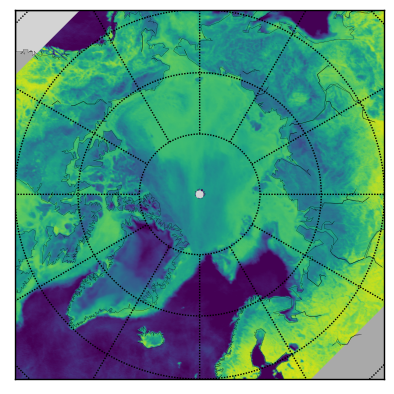

In [14]:
ArcticPlot(satlat,satlon,sat36H.mean(0),140,275)

### Trying manual interporation

In [15]:
# Take 2

RavSatLat = np.ravel(satlat)
RavSatLon = np.ravel(satlon)

SatPoints = np.stack([RavSatLat,RavSatLon],axis=1)

distance = []
min_index = []

ravLat = np.ravel(lat)
ravLon = np.ravel(lon)

ranMin = 0
ranMax = len(SatPoints)

for i in trange(len(ravLat)):

    dist = np.linalg.norm(SatPoints[ranMin:ranMax]-np.array([ravLat[i],ravLon[i]]), axis=1)
    index = np.argmin(dist)
    distance.append(dist[index])

    index += ranMin

    ranMin = index - 1000
    ranMax = index + 1000
    min_index.append(index)

distance = np.array(distance)
min_index = np.array(min_index)

  0%|          | 0/693528 [00:00<?, ?it/s]

In [16]:


# TAke 2
used_index = np.array([])
model_index = np.array([])

overlap = 0
missing = 0

ravData = np.ravel(TbV[19,1])

maxVal = 89

for i in trange(len(min_index)):
    
    ind = min_index[i]
    
    if ravData[i] == 0:
        missing += 1
        
    elif ravLat[i] > maxVal:
        missing += 1
        

    else:
        if ind in used_index:
            overlap += 1

        else:
            model_index = np.append(model_index,i).astype(int)
            used_index = np.append(used_index,ind).astype(int)

  0%|          | 0/693528 [00:00<?, ?it/s]

In [17]:
print(np.mean(distance),
     np.max(distance),
     np.mean(distance[distance < 1]),
     missing)

4.073360885380279 271.905398794335 0.09153542489335113 518907


## SMRT run 

In [18]:
smrtV,smrtH = [np.empty([len(freqs),int(len(ravLat[used_index]))]) for _ in range(2)]

ds = nc.Dataset(files[19])

ravSnowThickness = np.ravel(np.array(ds.variables["hs"][0]))[model_index]
ravIceThickness  = np.ravel(np.array(ds.variables["hi"][0]))[model_index]
ravSurfaceTemp   = np.ravel(np.array(ds.variables["Tsfc"][0] + 273.15))[model_index]

smrtLen = int(len(ravLat[model_index]))

smrtIndex = np.array([])

for i in trange(int(smrtLen/2)):
    
    i = i*2
    
    if np.floor(ravSnowThickness[i]*100) > 0:
            
        if ravIceThickness[i] >= 1.5:
            ice_type = 'multiyear'
            Type = 1

        else:
            ice_type = 'firstyear'
            Type = 0
            
        with suppress_stdout():
            try:
                smrtV[:,i],smrtH[:,i] = run_smrt(ravSnowThickness[i],ravIceThickness[i],ravSurfaceTemp[i],ice_type)
            except:
                break   

            
        smrtIndex = np.append(smrtIndex,i).astype(int)

  0%|          | 0/42375 [00:00<?, ?it/s]

In [19]:
np.save(directory + 'saves/smrtV2',smrtV)
np.save(directory + 'saves/smrtH2',smrtH)

In [20]:
#test0 = smrtH
#test1 = smrtV
#test2 = smrtIndex

In [21]:
smrtV = np.load(directory + 'saves/smrtV.npy')
smrtH = np.load(directory + 'saves/smrtH.npy')

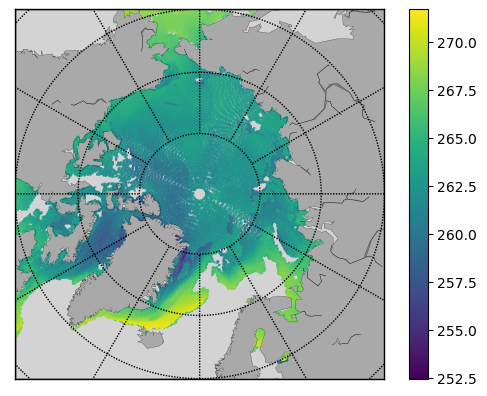

In [22]:
ArcticPlot(ravLat[model_index][smrtIndex],ravLon[model_index][smrtIndex],smrtV[:,smrtIndex][1,:])
plt.colorbar()
plt.show()

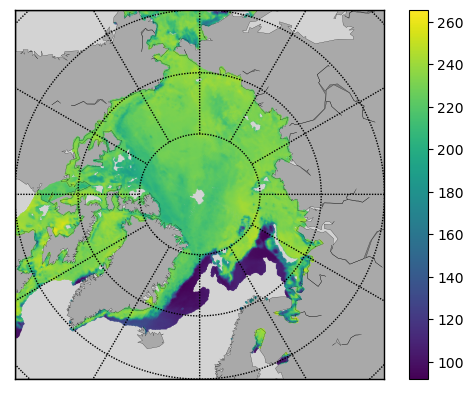

In [23]:
ArcticPlot(RavSatLat[used_index],RavSatLon[used_index],np.ravel(sat18H)[used_index])
plt.colorbar()

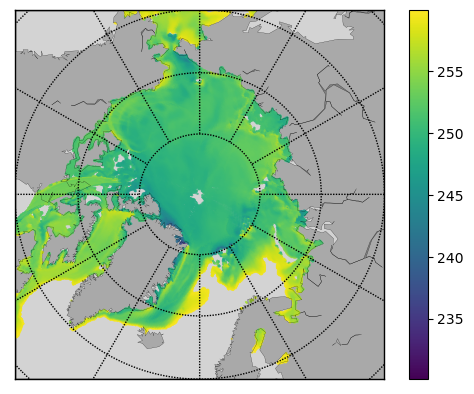

In [24]:
ArcticPlot(RavSatLat[used_index.astype(int)],RavSatLon[used_index.astype(int)],np.ravel(TbV[19,1,:,:])[model_index.astype(int)])
plt.colorbar()

In [25]:
a = np.abs(.1*np.ravel(sat18H)[used_index.astype(int)]-np.ravel(TbV[19,1,:,:])[model_index.astype(int)])
print([np.shape(used_index),np.shape(model_index)])

[(84750,), (84750,)]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

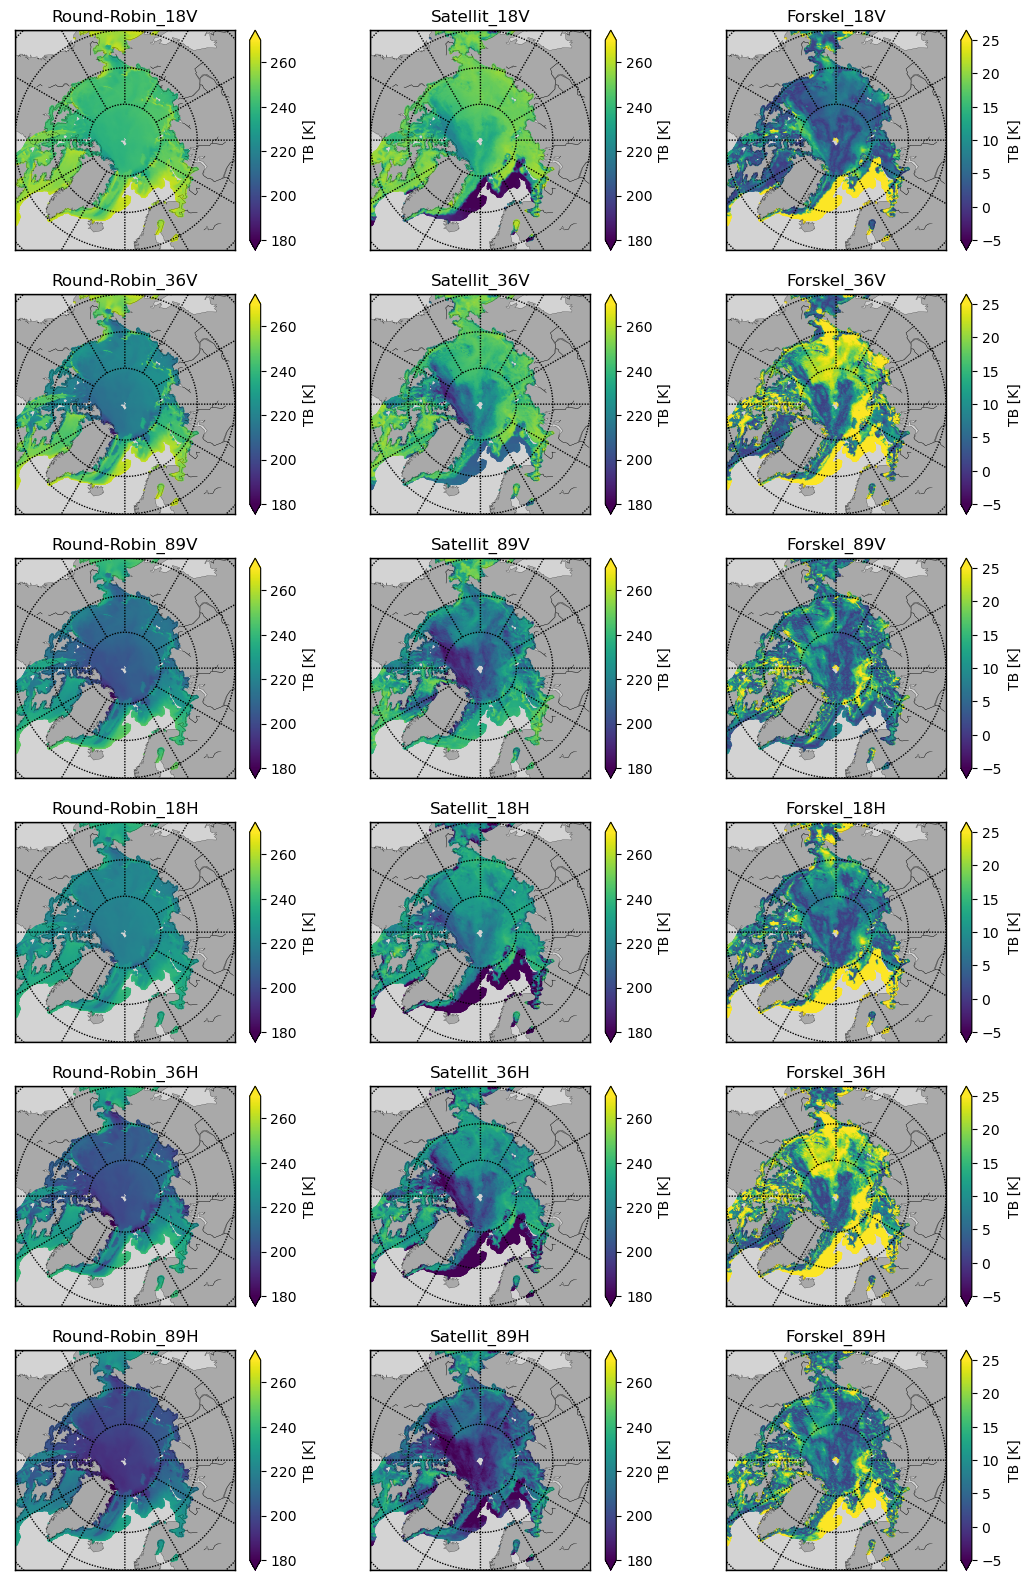

In [26]:
# Make a plot 2.0
# This is round robin vs sattelit

SatV = np.array([np.ravel(sat18V)[used_index],np.ravel(sat36V)[used_index],np.ravel(sat89V)[used_index]])
SatH = np.array([np.ravel(sat18H)[used_index],np.ravel(sat36H)[used_index],np.ravel(sat89H)[used_index]])

ModV = np.array([np.ravel(TbV[19,2])[model_index],np.ravel(TbV[19,3])[model_index],np.ravel(TbV[19,4])[model_index]])
ModH = np.array([np.ravel(TbH[19,2])[model_index],np.ravel(TbH[19,3])[model_index],np.ravel(TbH[19,4])[model_index]])

Names = np.array(['Round-Robin','Satellit','Forskel'])
Freq = np.array(['18V','36V','89V','18H','36H','89H'])

AllSat = np.concatenate([SatV,SatH])
AllMod = np.concatenate([ModV,ModH])

diff = AllSat-AllMod
data = np.array([AllMod,AllSat,diff])

plt.figure(figsize = (13,20))

for j in trange(3):
        
    for i in trange(6):
        plt.subplot(6,3,1 + i*3 + j)
    
        if j == 2:
            
            colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
            ArcticPlot(RavSatLat[used_index.astype(int)],RavSatLon[used_index.astype(int)],data[j,i],-5,25)

        else:
            colormap = plt.cm.get_cmap('viridis') # 'plasma' or 'viridis'
            ArcticPlot(RavSatLat[used_index.astype(int)],RavSatLon[used_index.astype(int)],data[j,i],180,270)

        plt.colorbar(label='TB [K]',extend = 'both')

        plt.title('{}_{}'.format(Names[j],Freq[i]))

plt.savefig(directory + 'Figures/RR_Sat.png', bbox_inches='tight')
plt.show()

In [27]:
np.shape(smrtV[2:,smrtIndex])

(3, 42375)

In [28]:
np.shape(AllSat[:,smrtIndex])

(6, 42375)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

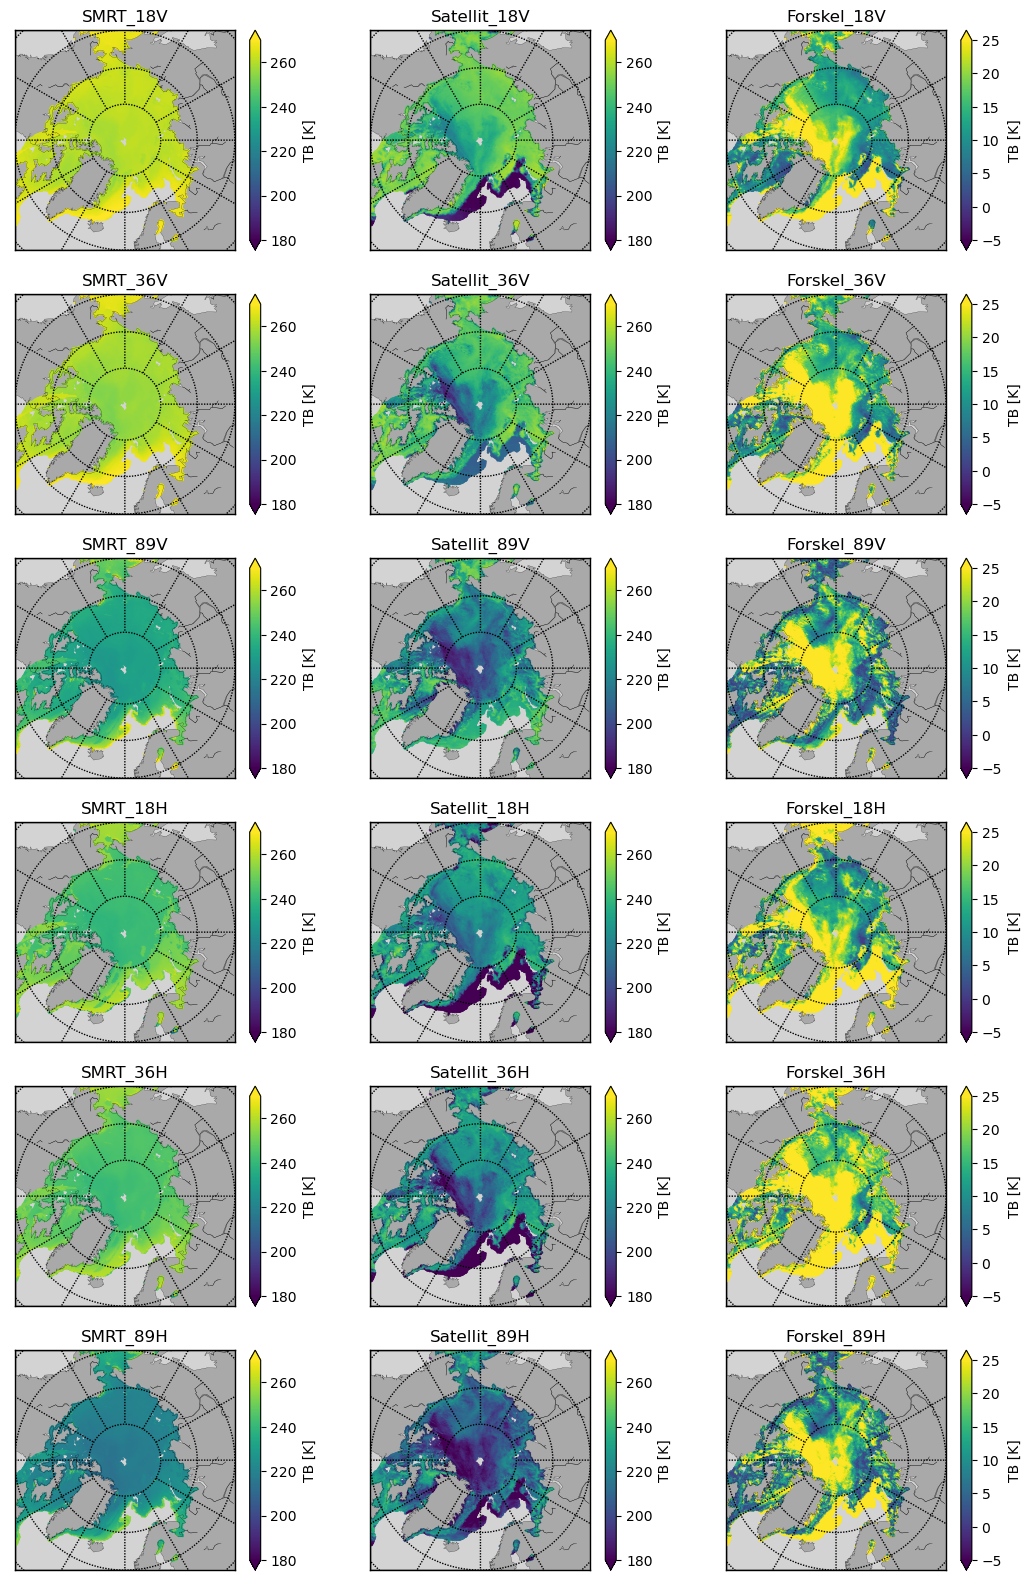

In [29]:
# Make a plot 2.0
# This is SMRT vs sat


Names_2 = np.array(['SMRT','Satellit','Forskel'])
Allsmrt = np.concatenate([smrtV[2:,smrtIndex],smrtH[2:,smrtIndex]],axis=0)

diff_2 = AllSat[:,smrtIndex]-Allsmrt
data_2 = np.array([Allsmrt,AllSat[:,smrtIndex],diff_2])

plt.figure(figsize = (13,20))

for j in trange(3):
        
    for i in trange(6):
        plt.subplot(6,3,1 + i*3 + j)
    
        if j == 2:
            
            #colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
            ArcticPlot(RavSatLat[used_index.astype(int)][smrtIndex],RavSatLon[used_index.astype(int)][smrtIndex],data_2[j,i],-5,25)

        else:
            #colormap = plt.cm.get_cmap('viridis') # 'plasma' or 'viridis'
            ArcticPlot(RavSatLat[used_index.astype(int)][smrtIndex],RavSatLon[used_index.astype(int)][smrtIndex],data_2[j,i],180,270)

        plt.colorbar(label='TB [K]',extend = 'both')

        plt.title('{}_{}'.format(Names_2[j],Freq[i]))

plt.savefig(directory + 'Figures/smrt_Sat.png', bbox_inches='tight')
plt.show()

In [30]:
for i in range(6):
    print(np.mean(diff[i,:]))

-8.783949671457256
2.3155317751641262
3.2458488019239784
-14.395930428428413
-3.746145089944389
-1.4471797041728114


In [31]:
# koden her skal vise hvordan forskellen er fordelt for hver af frekvenser og polariseringer
# Så skal den også fordele det ud fra GR tingen

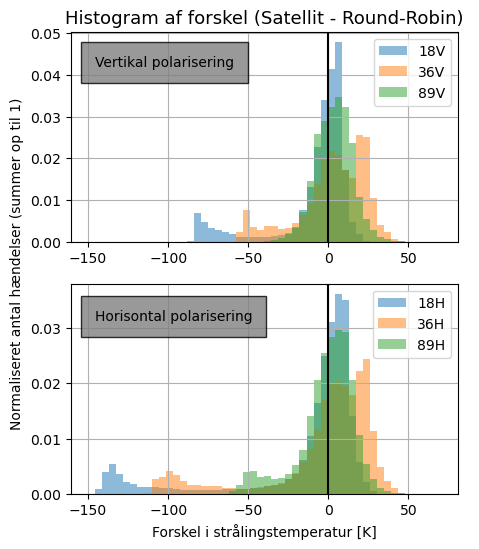

In [32]:
# RR
titles = ['Vertikal polarisering','Horisontal polarisering']

kwargs = dict(histtype='stepfilled', alpha=0.5, density=1, bins=50, range = (-150, 70))

fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

for j in range(2):
    
    fig.add_subplot(211+j)
    for i in range(3):
        plt.hist(diff[i+3*j],label=Freq[i+3*j],**kwargs)

    plt.axvline(0,color='k')
    plt.legend()
    plt.grid()
    
    plt.text(-146,0.042-j/94,titles[j],bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})

ax.set_title('Histogram af forskel (Satellit - Round-Robin)', fontsize=13)
ax.set_ylabel('Normaliseret antal hændelser (summer op til 1)')
ax.yaxis.set_label_coords(-.12,0.5)
plt.xlabel('Forskel i strålingstemperatur [K]')

plt.savefig(directory + 'Figures/hist_RR_Sat.png', bbox_inches='tight')
plt.show()

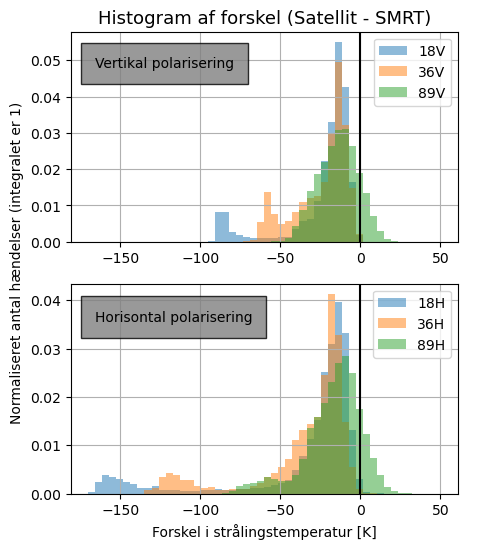

In [33]:
# SMRT

kwargs = dict(histtype='stepfilled', alpha=0.5, density=1, bins=50, range = (-170, 50))

fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

for j in range(2):
    
    fig.add_subplot(211+j)
    for i in range(3):
        ok = plt.hist(diff_2[i+3*j],label=Freq[i+3*j],**kwargs)

    plt.axvline(0,color='k')
    plt.legend()
    plt.grid()
    
    plt.text(-166,0.048-j/81,titles[j],bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})

ax.set_title('Histogram af forskel (Satellit - SMRT)', fontsize=13)
ax.set_ylabel('Normaliseret antal hændelser (integralet er 1)')
ax.yaxis.set_label_coords(-.12,0.5)
plt.xlabel('Forskel i strålingstemperatur [K]')

plt.savefig(directory + 'Figures/hist_smrt_Sat.png', bbox_inches='tight')
plt.show()

In [34]:
np.mean(np.round(GR*-12.5))

0.5943084050297816

In [35]:
# ok nu skal jeg udregn GR og bruge den til at vise forskellen.

GR = (ModV[1]-ModV[0]) / (ModV[1]+ModV[0]) # bruger den fra nasa websiten
#GR = (smrtV[3,smrtIndex]-smrtV[2,smrtIndex]) / (smrtV[3,smrtIndex]+smrtV[2,smrtIndex]) # bruger den fra nasa websiten
#GR = (Allsmrt[1]-Allsmrt[0]) / (Allsmrt[1]+Allsmrt[0]) # bruger den fra nasa websiten


Type = np.round(GR*-12.5)*np.arange(len(GR))

#Type = np.round(GR*-10)
#Everything under -0.05 is set to 1 and over is set to 0
# 0 is first year

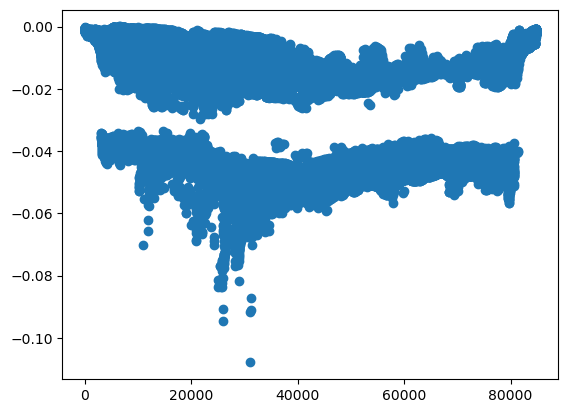

In [36]:
plt.scatter(range(len(GR)),GR)

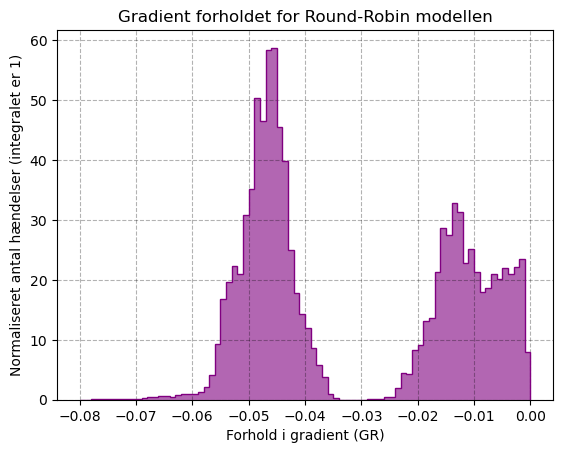

In [37]:
kwargs = dict(color = 'purple', density=0.1, bins=80, range = (-0.08, 0))


plt.grid(color = 'black',alpha=.3,linestyle = '--')
plt.hist(GR, histtype='step',**kwargs)
test =plt.hist(GR, histtype='bar', alpha = 0.6,**kwargs)

plt.title('Gradient forholdet for Round-Robin modellen')
plt.ylabel('Normaliseret antal hændelser (integralet er 1)')
plt.xlabel('Forhold i gradient (GR)')

plt.savefig(directory + 'Figures/hist_GR_RR.png', bbox_inches='tight')
plt.show()

In [38]:
np.shape(diff[0])

(84750,)

In [39]:
np.shape(diff[0][Type.astype(int) != 0])

(44641,)

In [40]:
84750/44641

1.8984789767254318

In [41]:
np.sum(test[0]*(np.max(test[1])-np.min(test[1])))

80.0

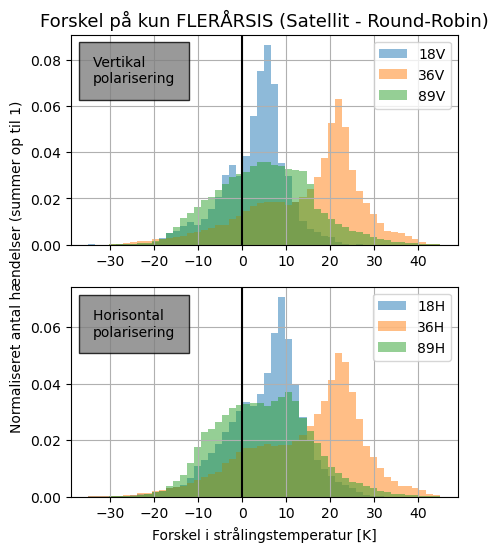

In [42]:
# RR
titles = ['Vertikal \npolarisering','Horisontal \npolarisering']


kwargs = dict(histtype='stepfilled', alpha=0.5, density=1, bins=50, range = (-35, 45))

fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot(111)

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

for j in range(2):
    
    fig.add_subplot(211+j)
    for i in range(3):
        plt.hist(diff[i+3*j][Type.astype(int) != 0],label=Freq[i+3*j],**kwargs)

    plt.axvline(0,color='k')
    plt.legend()
    plt.grid()
    
    plt.text(-34,0.070-j/76,titles[j],bbox={'facecolor': 'grey', 'alpha': 0.8, 'pad': 10})


ax.set_title('Forskel på kun FLERÅRSIS (Satellit - Round-Robin)', fontsize=13)
ax.set_ylabel('Normaliseret antal hændelser (summer op til 1)')
ax.yaxis.set_label_coords(-.12,0.5)
plt.xlabel('Forskel i strålingstemperatur [K]')

plt.savefig(directory + 'Figures/hist_Multiyear.png', bbox_inches='tight')
plt.show()

In [43]:
diff[0]

array([-78.73419937, -72.25059991, -79.10218127, ..., -12.1085788 ,
       -10.28283384, -12.16427529])

In [44]:
print(np.round(alpha))

[[ -2.  -3.  -0.   1. 239.]
 [ -1.  -9.   0.   2. 219.]
 [ -2. -14.  -0.   0. 246.]
 [ -2. -16.   0.   1. 220.]
 [ -4. -27.   0.  -5. 228.]
 [ -4. -26.   0.  -4. 197.]
 [ -5. -36.   0. -14. 165.]
 [ -6. -32.   1. -15. 103.]
 [ -2. -27.   1.  -9. -33.]
 [ -2. -25.   1.  -9. -79.]]


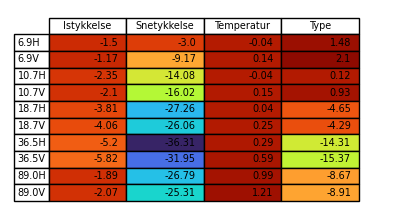

In [45]:
idx = Index(np.arange(1,11))
Freqs = np.array(['6.9H','6.9V','10.7H','10.7V','18.7H','18.7V','36.5H','36.5V','89.0H','89.0V'])
df = DataFrame(alpha[:,:4], index=Freqs, columns=['Istykkelse', 'Snetykkelse', 'Temperatur', 'Type'])

fig = plt.figure(figsize=(5,.1))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
vals = np.around(df.values,2)
norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.turbo(norm(alpha[:,:4]))


plt.table(cellText = vals,rowLabels=df.index,colWidths = [0.2 for _ in vals],colLabels=df.columns,cellColours=colours)
plt.savefig(directory + 'Figures/table.png', bbox_inches='tight')

plt.show()

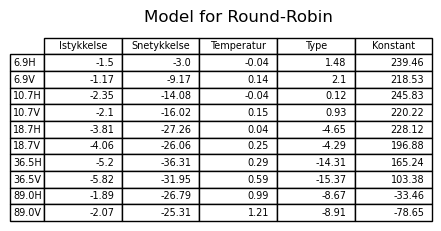

In [46]:
idx = Index(np.arange(1,11))
Freqs = np.array(['6.9H','6.9V','10.7H','10.7V','18.7H','18.7V','36.5H','36.5V','89.0H','89.0V'])
df = DataFrame(alpha[:,:], index=Freqs, columns=['Istykkelse', 'Snetykkelse', 'Temperatur', 'Type','Konstant'])

fig = plt.figure(figsize=(5,.1))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
vals = np.around(df.values,2)
norm = plt.Normalize(vals.min()-1, vals.max()+1)
colours = plt.cm.turbo(norm(alpha[:,:5]))


plt.table(cellText = vals,rowLabels=df.index,colWidths = [0.2 for _ in vals],colLabels=df.columns)#,cellColours=colours)
plt.savefig(directory + 'Figures/table2.png', bbox_inches='tight')

plt.title('Model for Round-Robin')
plt.show()